# Rolling window approach

Instead of GDF we apply rolling window approach to mid price and other features as in [3]
"Modeling high-frequency limit order book dynamics with support 
vector machines"

and try to use logistic regression on more features

In [1]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegressionCV

import warnings
import numpy as np
from collections import OrderedDict

from lob_data_utils import lob, db_result, overview, roc_results
from lob_data_utils.svm_calculation import lob_svm

sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

In [2]:
data_length = 10000
stock = '11869'

In [3]:
df = lob.load_prepared_data(
    stock, data_dir='../queue_imbalance/data/prepared', cv=False, include_test=False, length=None)
df.drop(columns=['bid', 'ask'], inplace=True)

In [4]:
df.rename(columns={'Unnamed: 0': 'datetime'}, inplace=True)
df.index = df['datetime']
df = df.sort_index()
print(min(df['datetime']), max(df['datetime']), len(df))
df.dropna(inplace=True)
df.head(5)

2013-09-02 09:00:00 2013-11-15 14:59:00 10567


,datetime,bid_price,ask_price,mid_price,sum_sell_ask,sum_buy_bid,mid_price_indicator,queue_imbalance
datetime,,,,,,,,
2013-09-02 09:00:00,2013-09-02 09:00:00,2617.0,2620.0,2618.5,237.0,198.0,0.0,-0.089655
2013-09-02 09:01:00,2013-09-02 09:01:00,2617.0,2619.0,2618.0,27.0,268.0,1.0,0.816949
2013-09-02 09:02:00,2013-09-02 09:02:00,2618.0,2621.0,2619.5,207.0,500.0,1.0,0.414427
2013-09-02 09:05:00,2013-09-02 09:05:00,2620.0,2621.0,2620.5,170.0,113.0,1.0,-0.201413
2013-09-02 09:06:00,2013-09-02 09:06:00,2621.0,2623.0,2622.0,171.0,350.0,1.0,0.343570


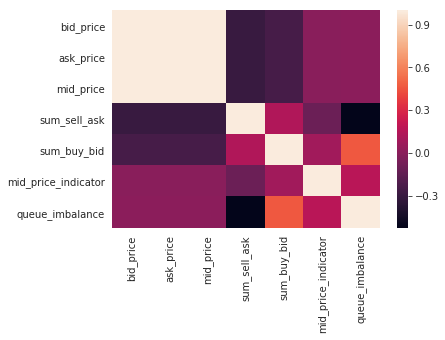

In [5]:
sns.heatmap(df.corr())

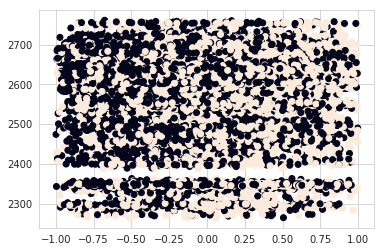

In [6]:
plt.scatter(df['queue_imbalance'], df['mid_price'], c=df['mid_price_indicator'])

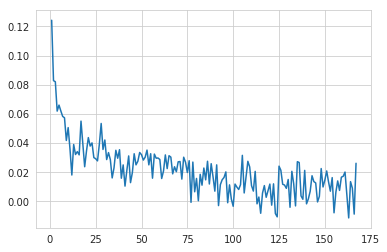

In [7]:
selectedLagPoints = [1,3,6,9,12,24,36,48,60]
maxLagDays = 7
allTimeLags = np.arange(1,maxLagDays*24)
autoCorr = [df['queue_imbalance'].autocorr(lag=dt) for dt in allTimeLags]
plt.plot(allTimeLags,autoCorr)
#plt.plot(df['queue_imbalance'])


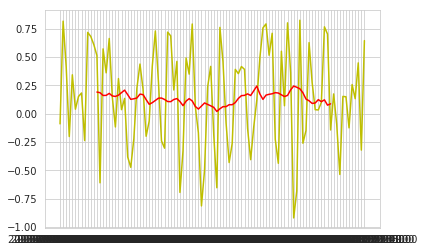

In [9]:
lowPassFilteredSignal = df['queue_imbalance'].iloc[0:100].rolling(24, center=True).mean()

plt.plot(df['queue_imbalance'].iloc[0:100],c='y')
plt.plot(lowPassFilteredSignal,c='r')
